In [19]:
pip install opencv-python openpyxl plotly statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 16.7 MB/s eta 0:00:00m eta 0:00:01:0102
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 9.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.11/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
# import sys
# sys.path.append("/home/e.sharaborin/snap/jupyter/common/lib/python3.7/site-packages")

import json
from datetime import datetime

import cv2 #for area calc
# import imutils

import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import plotly.io as pio
import glob, os, sys
import logging
from sys import argv
import re
import csv
from scipy.signal import find_peaks
from pathlib import Path
# pio.orca.config.executable = str(Path('C:/Users/Weugene/AppData/Local/Programs/orca/orca.exe'))
np.set_printoptions(threshold=sys.maxsize)
import scipy.spatial.distance as ds

import itertools
import operator
from scipy.interpolate import interp1d

def monotone_increasing(lst):
    pairs = zip(lst, lst[1:])
    return all(itertools.starmap(operator.lt, pairs))

def closest_point(arr_full, xi, yi, inds):
    N = arr_full.shape[0]
    arr_full[inds] = 1e+30
    dist = (arr_full[:, 0] - xi)**2 + (arr_full[:, 1] - yi)**2
    i_min = dist.argmin()
    return i_min, arr_full[i_min][0], arr_full[i_min][1]

def sort_by_nearest(arr):
    N = arr.shape[0]
    nearest_point = [None]*N
    #find initial point
    xmin = min(arr[:,0])
    xmax = max(arr[:,0])
    arr_cut = np.copy(arr)
    arr_cut[arr[:,0] > 0.5*(xmin + xmax)] = 10e+30
    iymin = arr_cut[:,1].argmin()
    x0, y0 = arr[iymin,0], arr[iymin,1]
    
    nearest_point[0] = [arr[iymin,0],arr[iymin,1]]
    print('Starting point:', x0, y0)
    print('MinMax point X:', xmin, xmax)
    observed = [iymin]
    i_min = iymin
    for i in range(1,N):
        xi, yi = arr[i_min]
        i_min, xip, yip = closest_point(arr, xi, yi, i_min)
        nearest_point[i] = [xip, yip]
        observed.append(i_min)
    nearest_point = np.array(nearest_point)
    return np.array(nearest_point), x0, xmin, xmax

def calc_delta(x, y, x0, x_rmax, x_cm):
#     mask = np.logical_and(x >= x_rmax + x0, x <= x_cm + x0)   
    mask = (x >= x_rmax + x0) * (x <= x_cm + x0) * (y>=0.4)
    delta_min = 0.5 - max(y[mask])
    delta_max = 0.5 - min(y[mask])
    print('***yMINMAX',min(y[mask]),max(y[mask]))
    print('----xMINMAX', min(x[mask]), max(x[mask]))
    
    ss = np.trapz(y=y[mask], x=x[mask])   
    
#     L = x_cm - x_rmax
    L = x[mask][-1] - x[mask][0]
    rad_mean = ss/L
    delta_mean = 0.5 - rad_mean
    print('S=', ss, ' L=', L, 'x_cm=', x_cm, 'x_rmax=', x_rmax, 'rad_mean=', rad_mean, 'delta_mean=', delta_mean)
    print('delta_min=', delta_min, 'delta_max=', delta_max, 'delta_mean=', delta_mean)
    return delta_min, delta_max, delta_mean 

#calculate polygon area
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))    
    
def myfft(t,f):
    if monotone_increasing(t):
        a = t[0]
        b = t[-1]
        T = b - a
        try:
            N = t.size
        except:
            N = len(t)
        fun = interp1d(t, f, kind='cubic')
        
        Nr = 10*N
        timestep = (b - a)/(Nr - 1)
        tr = np.linspace(a,b,Nr)
        fr = fun(tr)
        ss = np.trapz(y=fr, x=tr)   
        fr_mean = ss/T
        fr -= fr_mean
        freq = np.fft.fftfreq(Nr, d=timestep)
        sp = np.fft.fft(fr)
        sp = sp - np.mean(sp)
#         sp *= 0.5*(1 + np.tanh((freq**2 - FR**2)/smooth))
        freq, sp = zip(*sorted(zip(freq, sp)))
        return freq, sp
    else:
        return None, None

### STYLE
yaxis = dict(
              tickfont = dict(
              family = 'Times New Roman',
              size = 20,
              color = 'black'
              ),
              titlefont = dict(
                  family = 'Times New Roman',
                  size = 25,
                  color = 'black'
              ),
          )
xaxis = dict(
              tickfont = dict(
                  family = 'Times New Roman',
                  size = 20,
                  color = 'black'
              ),
              titlefont = dict(
                  family = 'Times New Roman',
                  size = 25,
                  color = 'black'
              )
          )
axis_style = dict(showline=True, gridwidth=1, gridcolor='lightgrey', linewidth=1, linecolor='black', mirror=True, ticks='outside',
                 tickfont = dict(family = 'Times New Roman', size = 18, color = 'black'))
bg_style = {'plot_bgcolor': 'rgba(255, 255, 255, 1)', 'paper_bgcolor': 'rgba(255, 255, 255, 1)',}
colors =   {'experiment':'blue', 'Fluent':'red', 'OpenFOAM':'hsv(120,100,100)', 'BPM':'black' }

### END of STYLE

diam = 0.514
rpath = f'{os.getenv("HOME")}/basilisk/work/tube/Contours_OpenFOAM_ANSYS_Experiment'


In [13]:
#gather all data into one table
from openpyxl import load_workbook, Workbook
files = [
    '10a.csv', '10a_Fluent_neighbors.csv', '10a_OpenFoam.csv', '10a_bpm_3.71054.csv',
    '10b.csv', '10b_Fluent_neighbors.csv', '10b_OpenFoam.csv', '10b_bpm_13.6235.csv',
    '10c.csv', '10c_Fluent_neighbors.csv', '10c_OpenFoam.csv', '10c_bpm_8.33802.csv',
    '10d.csv', '10d_Fluent_neighbors.csv', '10d_OpenFoam.csv', '10d_bpm_9.43375.csv',
    '10e.csv', '10e_Fluent_sorted.csv',    '10e_OpenFoam.csv', '10e_bpm_5.09939.csv'
]

names = {'10a':'AW1', '10b':'AW2', '10c':'AW3', '10d':'AW4', '10e':'AW5'}
def get_method(sheet):
    if 'bpm' in sheet:
        res = 'bpm'
    elif 'Fluent' in sheet:
        res = 'Fluent'
    elif 'OpenFoam' in sheet:
        res = 'OpenFOAM'
    else:
        res = 'experiment'
    return res

def generate_name(sheet):
    case = sheet[:3]
    res = names[case] + ':' + get_method(sheet) 
    return res

outfile = Path(rpath).joinpath("all_tables.xlsx") 
wb = Workbook()
wb.save(outfile)

book = load_workbook(outfile) 
with pd.ExcelWriter(outfile, engine='openpyxl')  as writer:
    writer.book = book
    found_csv = sorted(list(Path(rpath).glob('*.csv')))
    for i,file in enumerate(found_csv):
        basename = os.path.basename(file)
        sheet_name = basename[:-4]

        if basename in files:
            print(file)
            if 'bpm' in basename:
                df = pd.read_csv(file, usecols=['Points_0', 'Points_1'])
                df.rename(columns={"Points_0": "x", "Points_1": "y"}, inplace=True)
                if '10b' in basename:
                    df.drop(df[df['x'] > 19].index, inplace=True)
            else:
                df = pd.read_csv(file, names=['x', 'y'])
                df['x'] /= diam
                df['y'] /= diam
                
            df.to_excel(writer,sheet_name=sheet_name, engine='openpyxl', index=False)
            writer.save()


IndexError: At least one sheet must be visible

In [9]:
df_all = pd.read_excel(Path(rpath).joinpath('all_tables.xlsx'), sheet_name=None, header=0)
sheets = df_all.keys()

for case in ['10a', '10b', '10c', '10d', '10e']:
    print('CASE:', case)
    fig = go.Figure()
    for sheet in sheets:
        if case in sheet:
            try:
                df = df_all[sheet]
                df = df[df['y']>=0]
                x = df['x']
                y = df['y']
            except:
                print('error in sheet:', sheet)
            # sort array x, y. X ascending order
            arr_ = np.array((x,y)).T # make 2D array

            arr, x0, xmin, xmax = sort_by_nearest(arr_)
            x = arr[:,0]
            y = arr[:,1]

            if 'bpm' in sheet:
                t = sheet[9:14]
                
                peaks, props = find_peaks(y, prominence=0.005, height=0.35)
                print (peaks,props)
    #             print('rmax candidates=', y[peaks])
                rmax = y[peaks[0]]
                x_rmax = x[peaks[0]] - x0
                x_cm = x.mean() - x0 # center of mass
                fig.add_trace(go.Scatter(x=x-x0, y=y, name='t=' + t,
                                     mode='lines',
                                     marker = dict(
                                         color = colors['BPM'],
                                         size = 2
            #                                  ,
            #                              line = dict(
            #                               color = 'rgb(231, 99, 250)',
            #                               width = 12
            #                               )
                                     ),
                                     textfont=dict(
                                        family="Times New Roman",
                                        size=18,
                                        color="LightSeaGreen")
                                     ))
            else:
                meth = get_method(sheet)
                xmin = min(xmin, x0 + x.min())
                xmax = max(xmax, x0 + x.max())
                fig.add_trace(go.Scatter(x=x, y=y, name=meth,
                                     mode='lines',
                                     line=dict(color=colors[meth], width=2),
                                     textfont=dict(
                                        family="Times New Roman",
                                        size=18,
                                        color="LightSeaGreen")
                                     ))

            
    fig.add_trace(go.Scatter(x=[x_cm,x_cm], y=[0,0.6], name='x_cm',
                             mode='lines',
                             line=dict(color='black', width=2, dash='dot'),
                             textfont=dict(
                                family="Times New Roman",
                                size=18,
                                color="LightSeaGreen")
                             ))

    fig.add_trace(go.Scatter(x=[x_rmax,x_rmax], y=[0,0.6], name='x_rmax=',
                     mode='lines',
                     line=dict(color='black', width=2, dash='dot'),
                     textfont=dict(
                        family="Times New Roman",
                        size=18,
                        color="LightSeaGreen")
                     ))

    fig.add_trace(go.Scatter(
        x=[0, 4],
        y=[0.5, 0.5],
        mode='lines',
        line=dict(color='black', width=1),
        showlegend=False)
    )


#     fig.add_trace(go.Scatter(
#         x=[0, xmax - x0],
#         y=[-0.5, -0.5],
#         mode='lines',
#         line=dict(color='black', width=1),
#         showlegend=False)
#     )


    fig.update_layout(
        width = 1000,
        height = 315,
        xaxis_title='x',
        yaxis_title='y',
        yaxis = yaxis,
        xaxis = xaxis
    )
    fig.update_layout(bg_style)
    fig.update_xaxes(axis_style)
    fig.update_yaxes(axis_style)


    fig.update_layout(showlegend=False)
    fig.update_yaxes(range=[0,0.55])
#     fig.update_yaxes(dict(range=[0,0.55], showline=True, gridwidth=1, gridcolor='lightgrey', linewidth=1, 
#                           linecolor='black', mirror=True, ticks='outside',
#                  tickfont = dict(family = 'Times New Roman', size = 18, color = 'black')))
    fig.update_yaxes(
        scaleanchor = "x",
        scaleratio = 1
    )
    
    fig.update_yaxes(range=[0,0.55])
    fig.update_xaxes(range=[0,3.4])
    if True:
        fn = Path(rpath).joinpath('bubble_case=' + case + '.pdf')
        iplot(fig)
        pio.write_image(fig, str(Path(fn)))
        print("Successfully generated:", fn)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/weugene/basilisk/work/tube/Contours_OpenFOAM_ANSYS_Experiment/all_tables.xlsx'

## Plot scheme with xpeak, xcm xtail positions

CASE: 10e
Starting point: 0.0 0.0
MinMax point X: 0.0 1.6635019455252915
Starting point: 0.0 0.005892334389105058
MinMax point X: 0.0 1.5402952042801554
Starting point: 0.0 0.003589542463035019
MinMax point X: 0.0 1.671456766536965
Starting point: 4.0467949999999995 0.0037037
MinMax point X: 4.0467949999999995 5.7112
[121 188 230 270] {'peak_heights': array([0.452097, 0.448199, 0.436893, 0.438571]), 'prominences': array([0.4483933, 0.033403 , 0.009788 , 0.017335 ]), 'left_bases': array([  0, 159, 210, 210]), 'right_bases': array([672, 672, 249, 672])}


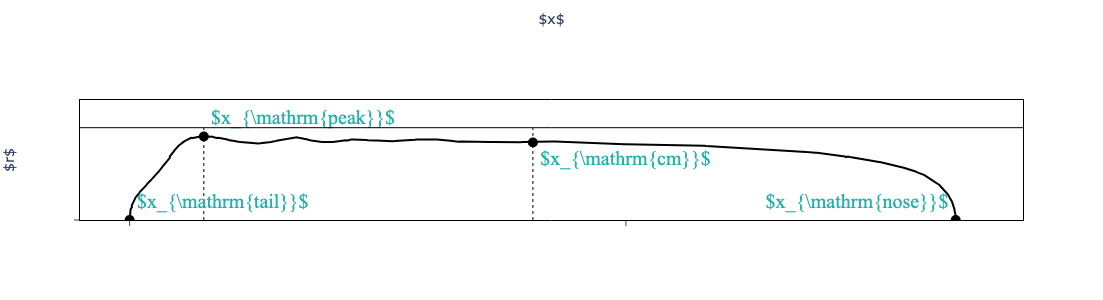

Successfully generated: /Users/weugene/basilisk/work/tube/Contours_OpenFOAM_ANSYS_Experiment/scheme_bubble.pdf


In [4]:
df_all = pd.read_excel(Path(rpath).joinpath('all_tables.xlsx'), sheet_name=None, header=0)
sheets = df_all.keys()

for case in ['10e']:
    print('CASE:', case)
    fig = go.Figure()
    for sheet in sheets:
        if case in sheet:
            try:
                df = df_all[sheet]
                df = df[df['y']>=0]
                x = 0.5*df['x']
                y = df['y']
            except:
                print('error in sheet:', sheet)
            # sort array x, y. X ascending order
            arr_ = np.array((x,y)).T # make 2D array

            arr, x0, xmin, xmax = sort_by_nearest(arr_)
            x = arr[:,0]
            y = arr[:,1]

            if 'bpm' in sheet:
                t = sheet[9:14]
                
                peaks, props = find_peaks(y, prominence=0.005, height=0.35)
                print (peaks,props)
    #             print('rmax candidates=', y[peaks])
                rmax = y[peaks[0]]
                x_rmax = x[peaks[0]] - x0
                x_cm = x.mean() - x0 # center of mass
                fig.add_trace(go.Scatter(x=x-x0, y=y, name='t=' + t,
                                     mode='lines',
                                     marker = dict(
                                         color = colors['BPM'],
                                         size = 2
            #                                  ,
            #                              line = dict(
            #                               color = 'rgb(231, 99, 250)',
            #                               width = 12
            #                               )
                                     ),
                                     textfont=dict(
                                        family="Times New Roman",
                                        size=18,
                                        color="LightSeaGreen")
                                     ))
#             else:
#                 meth = get_method(sheet)
#                 xmin = min(xmin, x0 + x.min())
#                 xmax = max(xmax, x0 + x.max())
#                 fig.add_trace(go.Scatter(x=x, y=y, name=meth,
#                                      mode='lines',
#                                      line=dict(color=colors[meth], width=2),
#                                      textfont=dict(
#                                         family="Times New Roman",
#                                         size=18,
#                                         color="LightSeaGreen")
#                                      ))

            
    fig.add_trace(go.Scatter(x=[x_cm,x_cm], y=[0,0.5], name='x_cm',
                             mode='lines',
                             line=dict(color='black', width=1, dash='dot'),
                             textfont=dict(
                                family="Times New Roman",
                                size=18,
                                color="LightSeaGreen")
                             ))

    fig.add_trace(go.Scatter(x=[x_rmax,x_rmax], y=[0,0.5], name='x_rmax=',
                     mode='lines',
                     line=dict(color='black', width=1, dash='dot'),
                     textfont=dict(
                        family="Times New Roman",
                        size=20,
                        color="LightSeaGreen")
                     ))
    
    fig.add_trace(go.Scatter(x=[0, x_rmax, x_cm, xmax-x0], y=[0, rmax, 0.42, 0], name='x_rmax=',
                     mode='markers+text',
                     text=['$x_{\mathrm{tail}}$', '$x_{\mathrm{peak}}$', '$x_{\mathrm{cm}}$', '$x_{\mathrm{nose}}$'],
                     textposition=["top right","top right","bottom right","top left"],
                     marker=dict(color='black', size=10),
                     textfont=dict(
                        family="Times New Roman",
                        size=20,
                        color="LightSeaGreen")
                     ))

    fig.add_trace(go.Scatter(
        x=[-10, 4],
        y=[0.5, 0.5],
        mode='lines',
        line=dict(color='black', width=1),
        showlegend=False)
    )


#     fig.add_trace(go.Scatter(
#         x=[0, xmax - x0],
#         y=[-0.5, -0.5],
#         mode='lines',        
#         line=dict(color='black', width=1),
#         showlegend=False)
#     )


    fig.update_layout(
        width = 400,
        height = 300,
        yaxis = yaxis,
        xaxis = xaxis
    )
    fig.update_xaxes(title='$x$', visible=True,tickmode = 'linear', showticklabels= False, showgrid=False)
    fig.update_yaxes(title='$r$', visible=True,tickmode = 'linear', showticklabels= False, showgrid=False)
    fig.update_layout(bg_style)
    fig.update_xaxes(axis_style)
    fig.update_yaxes(axis_style)


    fig.update_layout(showlegend=False)
#     fig.update_yaxes(dict(range=[0,0.55], showline=True, gridwidth=1, gridcolor='lightgrey', linewidth=1, 
#                           linecolor='black', mirror=True, ticks='outside',
#                  tickfont = dict(family = 'Times New Roman', size = 18, color = 'black')))
#     fig.update_yaxes(
#         scaleanchor = "x",
#         scaleratio = 2
#     )
    
    fig.update_yaxes(range=[0,0.65])
    fig.update_xaxes(range=[-0.1,1.8])
    if True:
        fn = Path(rpath).joinpath('scheme_bubble.pdf')
        iplot(fig)
        pio.write_image(fig, str(Path(fn)))
        print("Successfully generated:", fn)

In [14]:
from scipy.optimize import fsolve

diam = 0.514e-3
sigma = 72.8e-3
rho1=997

def calc_omega(k, h):
    return np.sqrt((sigma/rho1)*k**3*np.tanh(h*k))

def f(k, omega, h):
    return calc_omega(k, h) - omega


data = {'AW1':{'lambda': np.inf, 'u':0.242, 'delta':0.0134, 'omega_num': [None]}, 
 'AW2':{'lambda': 0.4716, 'u':0.666, 'delta':0.028, 'omega_num': [10.81e+3]},
 'AW3':{'lambda': 0.42, 'u':0.757, 'delta':0.031, 'omega_num': [12.28e+3]},
 'AW4':{'lambda': 0.42, 'u':1.118, 'delta':0.052, 'omega_num': [15.64e+3]},
 'AW5':{'lambda': 0.37, 'u':1.580, 'delta':0.072, 'omega_num': [12.2e+3, 29.85e+3, 24.42e+3, 32.12e+3]},
 'AW6':{'lambda': 0.28, 'u':2.060, 'delta':0.106, 'omega_num':[None]},
 'AW7':{'lambda': 0.2, 'u':2.575, 'delta':0.13, 'omega_num':[None]},
 'AW8':{'lambda': 0.4716, 'u':3.09, 'delta':0.16, 'omega_num':[None]},
}

for k,v in data.items():
    h = v['delta']*diam
    lambd = v['lambda']
    lam_dim = v['lambda']*diam
    k_wave = 2*np.pi/lam_dim
    omega1 = np.sqrt((sigma/rho1)*k_wave**3*np.tanh(h*k_wave))
    omega2 = np.sqrt((sigma/rho1)*k_wave**3)
    omega_num = np.asarray(v['omega_num'])
    if omega_num[0]:
        k_wave1 = np.zeros(len(omega_num))
        for i,omega in enumerate(omega_num):
            k_wave1[i] = fsolve(f, k_wave, args=(omega, h))
        k_wave2 = (rho1*omega_num**2/sigma)**(1./3.)
    else:
        k_wave1, k_wave2 = np.array(0), np.array(0)
    lambda1, lambda2 = np.where(k_wave1, 2*np.pi/(k_wave1)/diam, 0), np.where(k_wave2, 2*np.pi/(k_wave2)/diam, 0)
#     print(lambda1, k_wave1+1e-19)
    print(k, 'lambda=', np.round(lambd,7), 'k=', np.round(k_wave,2), 'omega1=', np.round(omega1,2), 'omega2=', np.round(omega2,2))
    print('Guess: k_wave1=', np.round(k_wave1,2), 'k_wave2=', np.round(k_wave2,2), 'lambda1=', np.round(lambda1,2), 'lambda2=', np.round(lambda2,2))
    

AW1 lambda= inf k= 0.0 omega1= 0.0 omega2= 0.0
Guess: k_wave1= 0 k_wave2= 0 lambda1= 0.0 lambda2= 0.0
AW2 lambda= 0.4716 k= 25920.47 omega1= 21296.41 omega2= 35660.1
Guess: k_wave1= [18365.87] k_wave2= [11696.93] lambda1= [0.67] lambda2= [1.05]
AW3 lambda= 0.42 k= 29104.99 omega1= 27924.47 omega2= 42429.64
Guess: k_wave1= [19118.18] k_wave2= [12734.64] lambda1= [0.64] lambda2= [0.96]
AW4 lambda= 0.42 k= 29104.99 omega1= 34247.58 omega2= 42429.64
Guess: k_wave1= [19209.29] k_wave2= [14962.78] lambda1= [0.64] lambda2= [0.82]
AW5 lambda= 0.37 k= 33038.1 omega1= 47042.92 omega2= 51314.56
Guess: k_wave1= [15726.07 25490.37 22811.29 26557.73] k_wave2= [12679.28 23022.41 20138.09 24175.29] lambda1= [0.78 0.48 0.54 0.46] lambda2= [0.96 0.53 0.61 0.51]
AW6 lambda= 0.28 k= 43657.49 omega1= 77281.57 omega2= 77948.22
Guess: k_wave1= 0 k_wave2= 0 lambda1= 0.0 lambda2= 0.0
AW7 lambda= 0.2 k= 61120.48 omega1= 129084.8 omega2= 129121.4
Guess: k_wave1= 0 k_wave2= 0 lambda1= 0.0 lambda2= 0.0
AW8 lambda=

/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_37875/1281558152.py:39: RuntimeWarning:

divide by zero encountered in divide

/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_37875/1281558152.py:35: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



# Contour convergene all contour

In [17]:
from pathlib import Path
from itertools import chain
import seaborn as sns

Jmax = [11, 12, 13]

fig = go.Figure()
colors_by_id =   {0:'blue', 1:'red', 2:'hsv(120,100,100)', 3:'black' }

for nj,j in enumerate(Jmax):
    print('jmax=', j)
    rootdir = f'{os.getenv("HOME")}/basilisk/work/tube/res20_Jmax={j}/'
    p = Path(rootdir)

    outfile = p.joinpath("table_slice_case20.xlsx") 
    wb = Workbook()
    wb.save(outfile)

    book = load_workbook(outfile) 
    with pd.ExcelWriter(outfile, engine='openpyxl')  as writer:
        writer.book = book
        found_csv = sorted(list(p.glob('slice*.csv')))
        for i,file in enumerate(found_csv):
            if i == len(found_csv) - 1:
                basename = os.path.basename(file)
                sheet_name = basename[:-4]
                print(basename, sheet_name)
                with open(file, 'r') as f:
                    lists = np.array(json.load(f)).T
                    df = pd.DataFrame(lists, columns =['x', 'y'])
                    df = df.loc[df['y']>=0]
                    xmin = df['x'].min()
                    df['x'] -= xmin
                    df = df.sort_values('x')
                    x, y = df['x'].values, df['y'].values
                    peaks, props = find_peaks(y, prominence=0.005, height=0.35)
                    print (peaks,props)
        #             print('rmax candidates=', y[peaks])
                    rmax = y[peaks[0]]
                    x_rmax = x[peaks[0]]
                    x_cm = x.mean() # center of mass
        #             display(df.head())
                    df.to_excel(writer,sheet_name=sheet_name, engine='openpyxl', index=False)
                    writer.save()
#                     sns.lineplot(x="x", y="y", data=df)
                    fig.add_trace(go.Scatter(x=df['x'], y=df['y'], name='$J_{\mathbf{max}}=' + str(j)+'$',
                                     mode='lines',
#                                      mode='lines',
                                     marker = dict(
                                         color = colors_by_id[nj],
                                         size = 2
            #                                  ,
            #                              line = dict(
            #                               color = 'rgb(231, 99, 250)',
            #                               width = 12
            #                               )
                                     ),
                                     textfont=dict(
                                        family="Times New Roman",
                                        size=18,
                                        color="LightSeaGreen")
                                     ))
fig.add_trace(go.Scatter(x=[x_cm,x_cm], y=[0,0.5], name='x_cm',
                             mode='lines',
                             line=dict(color='black', width=1, dash='dot'),
                             textfont=dict(
                                family="Times New Roman",
                                size=18,
                                color="LightSeaGreen"), showlegend=False
                             ))

fig.add_trace(go.Scatter(x=[x_rmax,x_rmax], y=[0,0.5], name='x_rmax=',
                 mode='lines',
                 line=dict(color='black', width=1, dash='dot'),
                 textfont=dict(
                    family="Times New Roman",
                    size=20,
                    color="LightSeaGreen"), showlegend=False
                 ))
fig.add_trace(go.Scatter(
    x=[-0.2, 3],
    y=[0.5, 0.5],
    mode='lines',
    line=dict(color='black', width=1),
    showlegend=False)
)

fig.update_layout(
    width = 1000,
    height = 330, #315
    xaxis_title='x',
    yaxis_title='y',
    yaxis = yaxis,
    xaxis = xaxis
)

fig.update_layout(bg_style)
fig.update_xaxes(axis_style)
fig.update_yaxes(axis_style)
fig.update_layout(legend=dict(
                                yanchor='top',
                                y=1,
                                xanchor='right',
                                x=1
))

fig.update_layout(showlegend=True)
fig.update_yaxes(range=[0,0.55])
#     fig.update_yaxes(dict(range=[0,0.55], showline=True, gridwidth=1, gridcolor='lightgrey', linewidth=1, 
#                           linecolor='black', mirror=True, ticks='outside',
#                  tickfont = dict(family = 'Times New Roman', size = 18, color = 'black')))
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1
)
# fig.update_xaxes(range=[-0.1,2.67])
if True:
    fn = Path(rpath).joinpath('profile_convergence.pdf')
    iplot(fig)
    pio.write_image(fig, str(Path(fn)))
    print("Successfully generated:", fn)

jmax= 11


<>:46: SyntaxWarning:

invalid escape sequence '\m'

<>:46: SyntaxWarning:

invalid escape sequence '\m'

/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_37875/2744007411.py:46: SyntaxWarning:

invalid escape sequence '\m'

/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_37875/2744007411.py:46: SyntaxWarning:

invalid escape sequence '\m'



FileNotFoundError: [Errno 2] No such file or directory: '/Users/evgeniisharaborin/basilisk/work/tube/res20_Jmax=11/table_slice_case20.xlsx'

## Zoomed in Convergence

In [18]:
from pathlib import Path
from itertools import chain
import seaborn as sns
import scipy.fftpack
from scipy.signal import savgol_filter
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy import interpolate
# from tsmoothie.smoother import 
from scipy.ndimage.filters import gaussian_filter1d

def smooth(xx, yy, N_main=400):
    N = xx.shape[0]
    f = interpolate.interp1d(xx, yy, kind='linear')
    x = np.linspace(xx.min(), xx.max(), N)
    y = f(x)

    w = scipy.fftpack.rfft(y)
    f = scipy.fftpack.rfftfreq(N, x[1]-x[0])
    spectrum = np.abs(w)**2
#     spectrum = sorted(spectrum)
#     cutoff_idx = np.arange(N) > N_main
    cutoff_idx = f > N_main/(x[1]-x[0])/N 
#     cutoff_idx = spectrum < 0.1
    print('SIZE:', len(w), N)
    w2 = w.copy()
    w2[cutoff_idx] = 0

    y2 = scipy.fftpack.irfft(w2)
    return x, y2

Jmax = [11, 12, 13]

fig = go.Figure()
colors_by_id =   {0:'blue', 1:'red', 2:'hsv(120,100,100)', 3:'black' }

for nj,j in enumerate(Jmax):
    print('jmax=', j)
    rootdir = '/Users/weugene/basilisk/work/tube/res20_Jmax={}/'.format(j)
    p = Path(rootdir)

    outfile = p.joinpath("table_slice_case20.xlsx") 
    wb = Workbook()
    wb.save(outfile)

    book = load_workbook(outfile) 
    with pd.ExcelWriter(outfile, engine='openpyxl')  as writer:
        writer.book = book
        found_csv = sorted(list(p.glob('slice*.csv')))
        for i,file in enumerate(found_csv):
            if i == len(found_csv) - 1:
                basename = os.path.basename(file)
                sheet_name = basename[:-4]
                print(basename, sheet_name)
                with open(file, 'r') as f:
                    lists = np.array(json.load(f)).T
                    df = pd.DataFrame(lists, columns =['x', 'y'])
                    df = df.loc[df['y']>=0]
                    xmin = df['x'].min()
                    df['x'] -= xmin
                    df = df.sort_values('x')
                    
                    
                    x, y = df['x'].values, df['y'].values
                    peaks, props = find_peaks(y, prominence=0.005, height=0.35)
                    print (peaks,props)
        #             print('rmax candidates=', y[peaks])
                    rmax = y[peaks[0]]
                    x_rmax = x[peaks[0]]
                    x_cm = x.mean() # center of mass
                    
                    
#                     df.drop_duplicates(subset=['x'])
                    if j == 12:
                        df['x'], df['y'] = smooth(df['x'].values, df['y'].values, 350)
#                         df['y'] = gaussian_filter1d(df['y'], sigma=0.1)
                    if j == 13:
#                         df['y'] = gaussian_filter1d(df['y'], sigma=0.1)
                        df['x'], df['y'] = smooth(df['x'].values, df['y'].values, 400)
#                         smoother = ConvolutionSmoother(window_len=3, window_type='blackman')
#                         smoother.smooth(df['y'])
#                         
                        
#                         df['y'] = smoother.smooth_data[0]

#                         kr = KernelReg(df['y'], df['x'], 'c')
#                         df['y'], y_std = kr.fit(df['x'])
#                         df['y'] = savgol_filter(df['y'], 21, 2) # window size 51, polynomial order 3

                    
        #             display(df.head())
                    df.to_excel(writer,sheet_name=sheet_name, engine='openpyxl', index=False)
                    writer.save()
#                     sns.lineplot(x="x", y="y", data=df)
                    fig.add_trace(go.Scatter(x=df['x'], y=df['y'], name='$J_{max}=' + str(j)+'$',
#                                      mode='markers',
                                     mode='lines',
                                     marker = dict(
                                         color = colors_by_id[nj],
                                         size = 2
                                     ),
                                     textfont=dict(
                                        family="Times New Roman",
                                        size=18,
                                        color="LightSeaGreen")
                                     ))
fig.add_trace(go.Scatter(x=[x_cm,x_cm], y=[0,0.5], name='x_cm',
                             mode='lines',
                             line=dict(color='black', width=1, dash='dot'),
                             textfont=dict(
                                family="Times New Roman",
                                size=18,
                                color="LightSeaGreen"), showlegend=False
                             ))

fig.add_trace(go.Scatter(x=[x_rmax,x_rmax], y=[0,0.5], name='x_rmax=',
                 mode='lines',
                 line=dict(color='black', width=1, dash='dot'),
                 textfont=dict(
                    family="Times New Roman",
                    size=20,
                    color="LightSeaGreen"), showlegend=False
                 ))

fig.add_trace(go.Scatter(
    x=[-0.2, 1],
    y=[0.5, 0.5],
    mode='lines',
    line=dict(color='black', width=1),
    showlegend=False)
)

fig.update_layout(
    width = 800,
    height = 300, #315
#     xaxis_title='x',
#     yaxis_title='y',
#     yaxis = yaxis,
#     xaxis = xaxis
)

fig.update_layout(bg_style)
fig.update_xaxes(axis_style)
fig.update_yaxes(axis_style)
fig.update_xaxes(title='', visible=True,tickmode = 'linear', showticklabels= False, showgrid=True)
fig.update_yaxes(title='', visible=True,tickmode = 'linear', showticklabels= False, showgrid=True)
    
fig.update_layout(showlegend=False)
fig.update_yaxes(range=[0.42,0.51])
fig.update_xaxes(range=[0.15,0.8])
#     fig.update_yaxes(dict(range=[0,0.55], showline=True, gridwidth=1, gridcolor='lightgrey', linewidth=1, 
#                           linecolor='black', mirror=True, ticks='outside',
#                  tickfont = dict(family = 'Times New Roman', size = 18, color = 'black')))
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1
)
# fig.update_xaxes(range=[-0.1,2.67])
if True:
    fn = Path(rpath).joinpath('profile_convergence_zoomed_in.pdf')
    iplot(fig)
    pio.write_image(fig, str(Path(fn)))
    print("Successfully generated:", fn)

ModuleNotFoundError: No module named 'statsmodels'

In [9]:
# from statsmodels.nonparametric.kernel_regression import KernelReg
# import numpy as np
# import matplotlib.pyplot as plt

# x = np.linspace(0,2*np.pi,100)
# y = np.sin(x) + np.random.random(100) * 0.2

# # The third parameter specifies the type of the variable x;
# # 'c' stands for continuous
# kr = KernelReg(y,x,'c')
# plt.plot(x, y, '+')
# y_pred, y_std = kr.fit(x)

# plt.plot(x, y_pred)
# plt.show()

# import numpy as np
# import scipy.fftpack

# N = 100
# x = np.linspace(0,2*np.pi,N)
# y = np.sin(x) + np.random.random(N) * 0.2

# w = scipy.fftpack.rfft(y)
# f = scipy.fftpack.rfftfreq(N, x[1]-x[0])
# spectrum = w**2

# cutoff_idx = spectrum < (spectrum.max()/5)
# w2 = w.copy()
# w2[cutoff_idx] = 0

# y2 = scipy.fftpack.irfft(w2)

# plt.plot(x, y, '+')
# plt.plot(x, y2)
# plt.show()

# import numpy as np
# import matplotlib.pyplot as plt
# from tsmoothie.smoother import *

# x = np.linspace(0,2*np.pi,100)
# y = np.sin(x) + np.random.random(100) * 0.1

# # operate smoothing
# smoother = ConvolutionSmoother(window_len=5, window_type='ones')
# smoother.smooth(y)

# # generate intervals
# low, up = smoother.get_intervals('sigma_interval', n_sigma=2)

# # plot the smoothed timeseries with intervals
# plt.figure(figsize=(11,6))
# plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
# plt.plot(smoother.data[0], '.k')
# # plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)

In [10]:
df.loc[(df['x'] > 0.415) & (df['x'] < 0.426)]

,x,y
2889,0.415200,0.469189
2896,0.416458,0.469024
2897,0.417716,0.468862
2904,0.418974,0.468750
2905,0.420233,0.468697
2912,0.421491,0.468648
2913,0.422749,0.468523
2920,0.424007,0.468285
2921,0.425265,0.467961


In [11]:
df_all = pd.read_excel(p.joinpath('table_slice_case20.xlsx'), sheet_name=None, header=0)
sheets = df_all.keys()

In [12]:
df=df_all['slice_t=9.10691']
sns.lineplot(x="x", y="y", data=df)

KeyError: 'slice_t=9.10691'

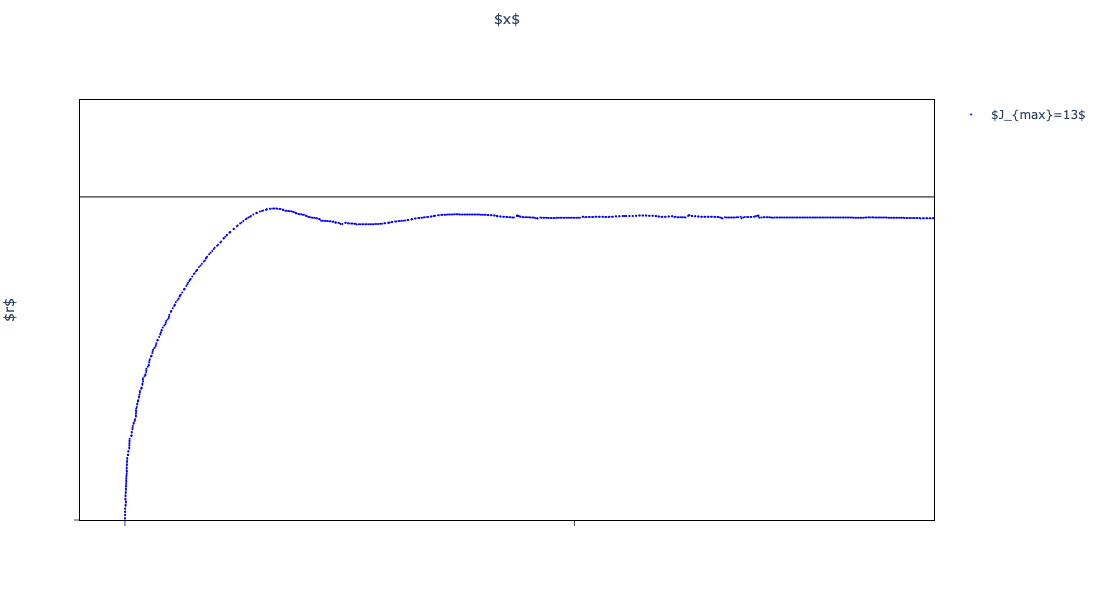

Successfully generated: /Users/weugene/basilisk/work/tube/Contours_OpenFOAM_ANSYS_Experiment/profile_convergence.pdf


In [13]:

dff = pd.read_csv('/Users/weugene/basilisk/work/tube/res20_Jmax=13/manually_sliced_t=8.86262.csv')
# sns.scatterplot(x="Points_0", y="Points_1", data=dff)

fig = go.Figure()
fig.add_trace(go.Scatter(x=dff['Points_0'] - dff['Points_0'].min(), y=dff['Points_1'], name='$J_{max}=' + str(13)+'$',
                                     mode='markers',
                                     marker = dict(
                                         color = colors_by_id[0],
                                         size = 2
            #                                  ,
            #                              line = dict(
            #                               color = 'rgb(231, 99, 250)',
            #                               width = 12
            #                               )
                                     ),
                                     textfont=dict(
                                        family="Times New Roman",
                                        size=18,
                                        color="LightSeaGreen")
                                     ))
fig.add_trace(go.Scatter(
        x=[-10, 4],
        y=[0.5, 0.5],
        mode='lines',
        line=dict(color='black', width=1),
        showlegend=False)
    )

fig.update_layout(
        width = 800,
        height = 600,
        yaxis = yaxis,
        xaxis = xaxis
    )
fig.update_xaxes(title='$x$', visible=True,tickmode = 'linear', showticklabels= False, showgrid=False)
fig.update_yaxes(title='$r$', visible=True,tickmode = 'linear', showticklabels= False, showgrid=False)
fig.update_layout(bg_style)
fig.update_xaxes(axis_style)
fig.update_yaxes(axis_style)
fig.update_layout(showlegend=True)
fig.update_yaxes(range=[0,0.65])
fig.update_xaxes(range=[-0.1,1.8])
if True:
    fn = Path(rpath).joinpath('profile_convergence.pdf')
    iplot(fig)
    pio.write_image(fig, str(Path(fn)))
    print("Successfully generated:", fn)

# Debugging peak finder in extract_isosurface.py

In [87]:
import json
from scipy.spatial import Delaunay
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * np.abs(s - a) * np.abs(s - b) * np.abs(s - c))
        circum_r = a * b * c / (4.0 * (area + 1e-16)) #corrected by Weugene
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

def find_min_max_curve(points, alpha, p0, pN):
    # Computing the alpha shape
    edges = alpha_shape(points, alpha=alpha, only_outer=True)
    #order edges
    edges = stitch_boundaries(edges)

    edge_points = np.zeros((len(edges),2))
    k=0
    for i, j in edges:
        edge_points[k,:] = points[[i, j], 0][0] , points[[i, j], 1][0]
        k += 1
    inodes, jnodes = zip(*edges)
    min_x_ind = np.argmin(np.linalg.norm(edge_points - p0,axis=1))
    max_x_ind = np.argmin(np.linalg.norm(edge_points - pN,axis=1))
    print("min_x_ind={} max_x_ind={}".format(min_x_ind, max_x_ind))
    #     min_x_ind = np.argmin(edge_points[:, 0])
    #     max_x_ind = np.argmax(edge_points[:, 0])
    if min_x_ind < max_x_ind:
        lower_hull = edge_points[min_x_ind:max_x_ind+1, :]
        upper_hull = np.concatenate([edge_points[max_x_ind:, :], edge_points[:min_x_ind+1, :]])
    else:
        upper_hull = edge_points[max_x_ind:min_x_ind+1, :]
        lower_hull = np.concatenate([edge_points[min_x_ind:, :], edge_points[:max_x_ind+1, :]])
    return lower_hull, upper_hull


def find_edges_with(i, edge_set):
    i_first = [j for (x,j) in edge_set if x==i]
    i_second = [j for (j,x) in edge_set if x==i]
    return i_first,i_second

def stitch_boundaries(edges):
    edge_set = edges.copy()
    boundary_lst = []
    while len(edge_set) > 0:
        boundary = []
        edge0 = edge_set.pop()
        boundary.append(edge0)
        last_edge = edge0
        while len(edge_set) > 0:
            i,j = last_edge
            j_first, j_second = find_edges_with(j, edge_set)
            if j_first:
                edge_set.remove((j, j_first[0]))
                edge_with_j = (j, j_first[0])
                boundary.append(edge_with_j)
                last_edge = edge_with_j
            elif j_second:
                edge_set.remove((j_second[0], j))
                edge_with_j = (j, j_second[0])  # flip edge rep
                boundary.append(edge_with_j)
                last_edge = edge_with_j

            if edge0[0] == last_edge[1]:
                break

        boundary_lst.append(boundary)
    return boundary_lst[0]


def calc_thickness(x, y, x_peak, x_mean, prefix):
    # calculate actual min max thickness and averaged min max values of thickness
    args = (x >= x_peak) & (x <= x_mean)
    y_ripple_slice = y[args]
    delta_min = 0.5 - y_ripple_slice.max()
    delta_max = 0.5 - y_ripple_slice.min()
    delta_avg = 0.5 - y_ripple_slice.mean()
    delta_avg_std = np.std(y_ripple_slice, ddof=1)
    print("Estimated delta_{}".format(prefix), 'delta_min=', delta_min, 'delta_max=', delta_max, 'delta_avg=', delta_avg, 'delta_avg_std=', delta_avg_std, 'NOTE: here avg is calcculated differently')
    return delta_min, delta_max, delta_avg, delta_avg_std

def find_first_peak(x_fil, y_fil, x0, xmin, xmax, x_mean, time):
    if x_fil[0] > x_fil[-1]:
        x_fil = x_fil[::-1]
        y_fil = y_fil[::-1]
    ind = np.argmax(y_fil)
    print("max ={} {}".format(x_fil[ind], y_fil[ind]))
    #choose some points if they are:
    args = (y_fil >= 0.3) & (x_fil <= x_mean)
    x_ripple = x_fil[args]
    y_ripple = y_fil[args]

    print("sizes of ripple:{} {}".format(x_ripple.shape, y_ripple.shape))
    #return 0, 0, 0, 0, 0, 0, 0
    #find the first peak in a smoothed curve
    peaks, props = find_peaks(y_ripple, prominence=0.0001)
    print("peaks, props:", peaks, props)
    try:
        x_peak, y_peak = x_ripple[peaks[0]], y_ripple[peaks[0]]
    except:
        x_peak, y_peak = np.inf, np.inf
    length_x_peak_mean = x_mean - x_peak
    print('x_peak candidates=', x_ripple[peaks], 'y_peak candidates=', y_ripple[peaks])
    print('x_peak', x_peak, 'y_peak=', y_peak, "length_x_peak_mean=", length_x_peak_mean)
    if not x_peak:
        x_peak = x_mean
        y_peak = 0.5
        length_x_peak_mean = 0
    return x_peak, y_peak, length_x_peak_mean

def find_smooth_curve_and_bounds(x, y, x_mean, alpha = 0.01):
    # calculate xmin, xmax, ymin, ymax
    xmin, xmax = min(x), max(x)
    ymin, ymax = min(y), max(y)
    # calculate xy0, xyN
    inds = x < x_mean
    ind_xy0 = y[inds].argmin()
    xy0 = x[inds][ind_xy0], y[inds][ind_xy0]
    inds = x > x_mean
    ind_xyN = y[inds].argmin()
    xyN = x[inds][ind_xyN], y[inds][ind_xyN]
    length_x_clip_ends = xyN[0] - xy0[0]
    #preprocess x, y arrays using histogram:
    N = 10000
    xedges = xmin + (xmax - xmin)*np.linspace(0,1,N)
    yedges = ymin + (ymax - ymin)*np.linspace(0,1,N)
    H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
    X, Y = np.meshgrid(xedges, yedges)
    # Histogram does not follow Cartesian convention (see Notes),
    # therefore transpose H for visualization purposes.
    H = H.T *(255.0/H.max())
    N_non_zero = np.count_nonzero(H)
    coords = np.zeros((N_non_zero, 2))
    k = 0
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            if H[i,j]>0:
                coords[k,:] = X[i,j], Y[i,j]
                k += 1
    del X, Y, H
    # upper and lower lines
    lower_hull, upper_hull = find_min_max_curve(np.asarray(coords), alpha = alpha, p0=xy0, pN=xyN)
    plt.plot(lower_hull[:,0], lower_hull[:,1])
    plt.plot(upper_hull[:,0], upper_hull[:,1])
    plt.show()
    print("lower_hull and upper_hull minmax<><><><>", min(lower_hull[:,0]), max(lower_hull[:,0]), min(upper_hull[:,0]), max(upper_hull[:,0]))

    x_peak, y_peak, length_x_peak_mean = find_first_peak(upper_hull[:,0], upper_hull[:,1], xy0[0], xmin, xmax, x_mean, 0)


    delta_min_lw, delta_max_lw, delta_avg_lw, delta_avg_std_lw = calc_thickness(lower_hull[:,0], lower_hull[:,1], x_peak, x_mean, 'lower_hull')
    delta_min_up, delta_max_up, delta_avg_up, delta_avg_std_up = calc_thickness(upper_hull[:,0], upper_hull[:,1], x_peak, x_mean, 'upper_hull')
    delta_min, delta_max, delta_avg, delta_avg_std = calc_thickness(x, y, x_peak, x_mean, 'sliced_x_y')

    return lower_hull, upper_hull, x_peak, y_peak, length_x_peak_mean, delta_min, delta_max, xy0, xyN, xmin, xmax


In [88]:
rt = '/Users/weugene/basilisk/work/tube/r_over_x_total_t=8.86262.csv'
# read files as below:
with open(rt, 'r') as f:
    lists = json.load(f)
    x, y = np.array(lists[0]), np.array(lists[1])

min_x_ind=1552 max_x_ind=653


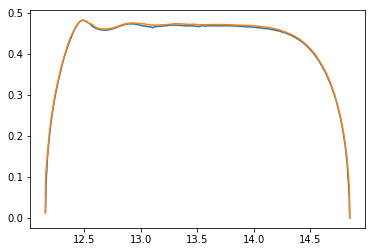

lower_hull and upper_hull minmax<><><><> 12.153754234313965 14.849815024436861 12.153754234313965 14.850894096195965
max =12.485029264359083 0.48195147704632363
sizes of ripple:(382,) (382,)
peaks, props: [109 187 251 278 287 291 316 331 347 354 364 372 378] {'prominences': array([0.02164395, 0.00019282, 0.00544714, 0.00159076, 0.00043384,
       0.00014461, 0.00024102, 0.00014461, 0.00028923, 0.00250665,
       0.00072307, 0.00043384, 0.00053025]), 'left_bases': array([  0, 185, 185, 277, 286, 290, 293, 293, 293, 293, 363, 371, 371]), 'right_bases': array([183, 188, 288, 288, 288, 293, 318, 333, 351, 381, 381, 373, 381])}
x_peak candidates= [12.48502926 12.69032267 12.92124402 13.02726282 13.09713272 13.11547694
 13.17779333 13.23255623 13.29864937 13.33156106 13.37930998 13.41950541
 13.47103108] y_peak candidates= [0.48195148 0.46064496 0.47529922 0.47423871 0.47047874 0.46999669
 0.47071976 0.47163565 0.47346743 0.47351564 0.47327462 0.4721659
 0.47221411]
x_peak 12.485029264359083

In [89]:
x_mean = 0.5*(x.min() + x.max())
lower_hull, upper_hull, x_peak, y_peak, length_x_peak_mean, delta_min, delta_max, xy0, xyN, xmin, xmax =  find_smooth_curve_and_bounds(x, y, x_mean, alpha = 0.05)